In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import os
import sys
import datetime
import time
import torch

from PIL import Image, ImageFont, ImageDraw
from glob import glob

In [3]:
os.getcwd()

'/Users/ryan/ai/3d_imaging_project/section3/src'

## Get Paths

In [4]:
data_path = os.path.join("..", "data", "TestVolumes")
study_path = os.path.join(data_path, "Study1")
hcrop_dcm_path = os.path.join(study_path, "13_HCropVolume", "18.dcm")
non_hcrop_dcm_path = os.path.join(study_path, "12-T1post-05670", "000011.dcm")

In [5]:
hcrop = pydicom.dcmread(hcrop_dcm_path)
norm = pydicom.dcmread(non_hcrop_dcm_path)

In [6]:
dcm_files = glob(os.path.join(study_path, "**", "*.dcm"), recursive=True)

## Examine Headers

In [7]:
hcrop

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 262
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.11626594442255127588609191835064947197
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.76647264891085702040065110813461770521
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 1.4.0'
(0002, 0016) Source Application Entity Title     AE: 'DicomBrowser'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.11626594442255127588

## Read in all DICOM files

In [8]:
all_dcm = [pydicom.dcmread(file) for file in dcm_files]

In [9]:
len(all_dcm)

120

## Unique Header Values

In [10]:
np.unique([dcm.ImageType[0] for dcm in all_dcm])

array(['DERIVED', 'ORIGINAL'], dtype='<U8')

In [11]:
np.unique([dcm.SeriesDescription for dcm in all_dcm])

array(['FLAIR_reg', 'HippoCrop', 'T1post', 'T1pre_reg', 'T2_reg'],
      dtype='<U9')

In [12]:
np.unique([dcm.SeriesInstanceUID for dcm in all_dcm])

array(['1.2.826.0.1.3680043.8.498.10112548596522579645160189153146185462',
       '1.3.6.1.4.1.14519.5.2.1.4429.7055.193040451353874948984496684610',
       '1.3.6.1.4.1.14519.5.2.1.4429.7055.199005955963638011349611688910',
       '1.3.6.1.4.1.14519.5.2.1.4429.7055.228775196332831153589141676244',
       '1.3.6.1.4.1.14519.5.2.1.4429.7055.944388794957680958886578505670'],
      dtype='<U64')

## Pull Out Localized Hippocampus Slices

In [79]:
hippo_dcm = [dcm for dcm in all_dcm if dcm.SeriesDescription == "HippoCrop"]

vol_len = int(hippo_dcm[0].ImagesInAcquisition)

slices = [None] * vol_len
for dcm in hippo_dcm:
    slices[int(dcm.InstanceNumber)-1] = dcm.pixel_array

slices = np.array(slices)
slices.shape

(32, 51, 35)

In [80]:
orig_vol = slices
inference = {"anterior": 2300, "posterior": 2200, "total": 4500}

In [167]:
def pad_to_shape(img, shape):
    x_gap = shape[0] - img.shape[0]
    y_gap = shape[1] - img.shape[1]
    x_pad = (x_gap // 2, x_gap - (x_gap // 2))
    y_pad = (y_gap // 2, y_gap - (y_gap // 2))
    return np.pad(img, [x_pad, y_pad], mode='constant')
    

In [219]:
pimg = Image.new("RGB", (1000, 1000))
draw = ImageDraw.Draw(pimg)

header_font = ImageFont.truetype("assets/Roboto-Regular.ttf", size=40)
main_font = ImageFont.truetype("assets/Roboto-Regular.ttf", size=20)

slice_nums = [orig_vol.shape[2]//3, orig_vol.shape[2]//2, orig_vol.shape[2]*3//4] # is there a better choice?

axial = np.zeros((orig_vol.shape[1], orig_vol.shape[2]))
for i in range(orig_vol.shape[0]):
    axial += orig_vol[i,:,:]
    
axial = ((axial / np.max(axial)) * 0xff).astype(np.uint8)
axial = pad_to_shape(axial, (64, 64))
    
sagittal = np.zeros((orig_vol.shape[0], orig_vol.shape[2]))
for i in range(orig_vol.shape[1]):
    sagittal += orig_vol[:,i,:]
    
sagittal = ((sagittal / np.max(sagittal)) * 0xff).astype(np.uint8)
sagittal = pad_to_shape(sagittal, (64, 64))
    
coronal = np.zeros((orig_vol.shape[0], orig_vol.shape[1]))
for i in range(orig_vol.shape[2]):
    coronal += orig_vol[:,:,i]
    
coronal = ((coronal / np.max(coronal)) * 0xff).astype(np.uint8)
coronal = pad_to_shape(coronal, (64, 64))


# TASK: Create the report here and show information that you think would be relevant to
# clinicians. A sample code is provided below, but feel free to use your creative 
# genius to make if shine. After all, the is the only part of all our machine learning 
# efforts that will be visible to the world. The usefulness of your computations will largely
# depend on how you present them.

# SAMPLE CODE BELOW: UNCOMMENT AND CUSTOMIZE
draw.text((10, 0), "HippoVolume.AI", (255, 255, 255), font=header_font)
draw.multiline_text((10, 90),
f"""
Patient ID: {12345}
Hippocampus Volume
    - Anterior:__{inference['anterior']} mm^3
    - Posterior:_{inference['posterior']} mm^3
    - Total:_____{inference['total']} mm^3
""",
                    (255, 255, 255), font=main_font)

axial_img = Image.fromarray(axial, mode='L').convert('RGBA')
sagittal_img = Image.fromarray(sagittal, mode='L').convert('RGBA')
coronal_img = Image.fromarray(coronal, mode='L').convert('RGBA')

draw.text((10, 500), "2D Axial View", (255, 255, 255), font=main_font)
draw.text((420, 10), "2D Sagittal View", (255, 255, 255), font=main_font)
draw.text((420, 500), "2D Coronal View", (255, 255, 255), font=main_font)


pimg.paste(axial_img.resize((400,400)), box=(40,520))
pimg.paste(sagittal_img.resize((400,400)), box=(420,40))
pimg.paste(coronal_img.resize((400,400)), box=(420,520))

In [241]:
pred_vol = orig_vol
pred_anterior = ((orig_vol / np.max(orig_vol)) < 0.3).astype(int)
pred_posterior = ((orig_vol / np.max(orig_vol)) > 0.4).astype(int)

axial_anterior = np.zeros((pred_vol.shape[1], pred_vol.shape[2]))
axial_posterior = np.zeros((pred_vol.shape[1], pred_vol.shape[2]))
for i in range(pred_vol.shape[0]):
    axial_anterior += pred_anterior[i,:,:]
    axial_posterior += pred_posterior[i,:,:]

sagittal_anterior = np.zeros((pred_vol.shape[0], pred_vol.shape[2]))
sagittal_posterior = np.zeros((pred_vol.shape[0], pred_vol.shape[2]))
for i in range(pred_vol.shape[1]):
    sagittal_anterior += pred_anterior[:,i,:]
    sagittal_posterior += pred_posterior[:,i,:]

coronal_anterior = np.zeros((pred_vol.shape[0], pred_vol.shape[1]))
coronal_posterior = np.zeros((pred_vol.shape[0], pred_vol.shape[1]))
for i in range(pred_vol.shape[2]):
    coronal_anterior += pred_anterior[:,:,i]
    coronal_posterior += pred_posterior[:,:,i]

In [283]:
rgbpred = np.zeros((pred_vol.shape[0], pred_vol.shape[1], pred_vol.shape[2], 3))
rgbpred.shape

(32, 51, 35, 3)

In [312]:
rgbpred[:,:,:,1] += pred_anterior
rgbpred[:,:,:,2] += pred_posterior

axial_rgb = np.zeros((rgbpred.shape[1], rgbpred.shape[2], rgbpred.shape[3]))
for i in range(rgbpred.shape[0]):
    axial_rgb += rgbpred[i,:,:,:]

temp = np.zeros((64, 64, 3))
for chan in range(3):
    temp[:,:,chan] += pad_to_shape(axial_rgb[:,:,chan], (64,64))

axial_rgb = temp
axial_rgb = ((axial_rgb / np.max(axial_rgb)) * 0xff).astype(np.uint8)
axial_mask = Image.fromarray(axial_rgb, mode='RGB').convert('RGBA')

In [308]:
flat_axial = np.zeros((64, 64, 3))
flat_axial[:,:,1] += pad_to_shape(axial_anterior, (64,64))
flat_axial[:,:,2] += pad_to_shape(axial_posterior, (64,64))

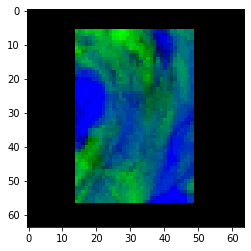

In [310]:
plt.imshow(flat_axial / np.max(flat_axial))

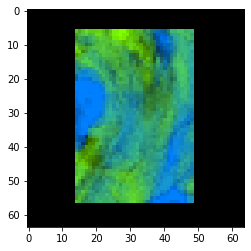

In [313]:
plt.imshow(axial_mask)

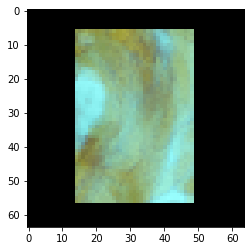

In [306]:
plt.imshow(Image.blend(axial_img, axial_mask, 0.4))

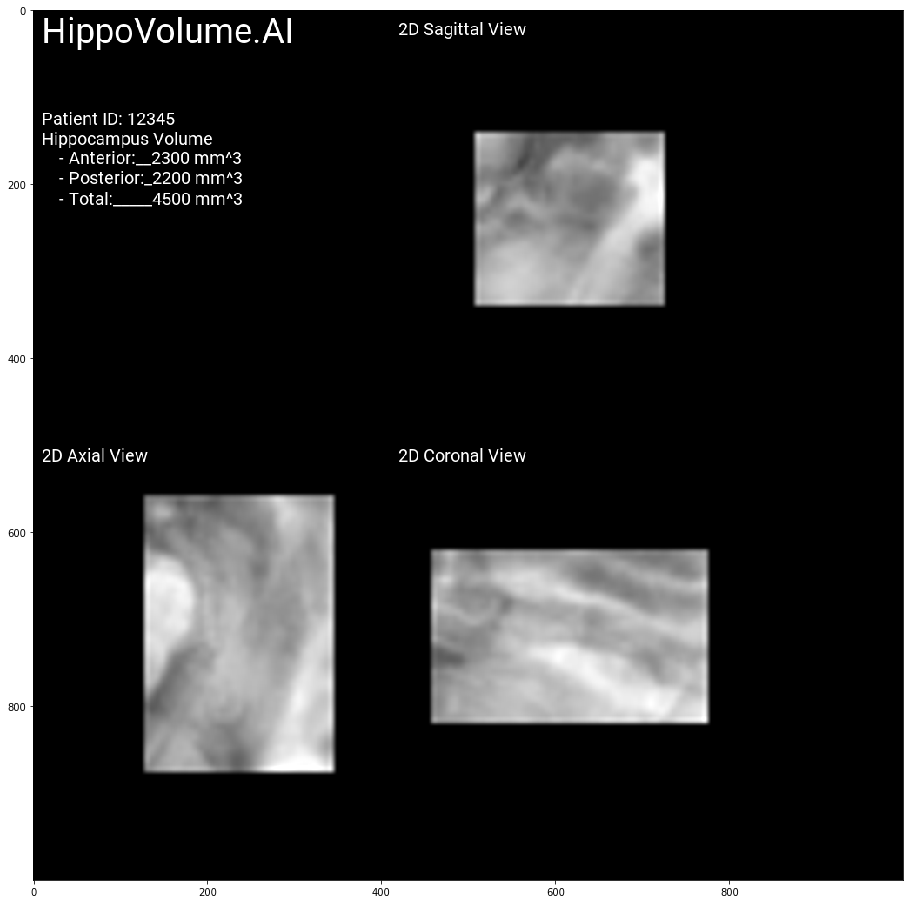

In [220]:
plt.figure(figsize=(16,16))
plt.imshow(pimg)

In [325]:
report = pydicom.dcmread(os.path.join("..", "reports", "report.dcm"))

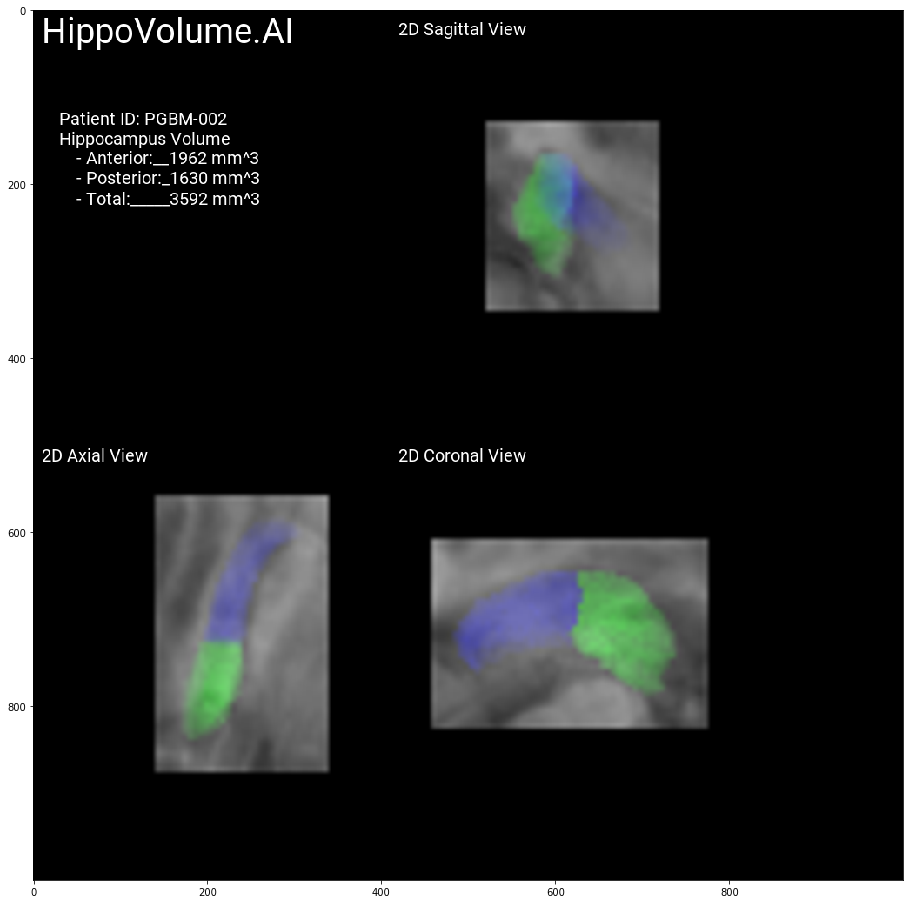

In [326]:
plt.figure(figsize=(16, 16))
plt.imshow(report.pixel_array)